In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in _:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# /kaggle/input/test-5280-competition-video-hgr/validation/validation/annotations.txt
# /kaggle/input/test-5280-competition-video-hgr/train/train/RIGHT/SNB_RIGHT_00135/img_00056.jpg


In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
from pathlib import Path
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time

In [3]:
BASE_DATA_PATH = Path("/home/ian/Documents/UNT/wearables/kaggle/data/video")

TRAIN_VIDEO_ROOT = BASE_DATA_PATH / "train" / "train" 
TRAIN_ANNOTATIONS_ROOT = BASE_DATA_PATH / "train" / "train" / "annotations.txt"

VALIDATION_VIDEO_ROOT = BASE_DATA_PATH / "validation" / "validation" 
VALIDATION_ANNOTATIONS_ROOT = BASE_DATA_PATH / "validation" / "validation" / "annotations.txt"

TEST_VIDEO_ROOT = BASE_DATA_PATH / "test" / "test" 
TEST_ANNOTATIONS_ROOT = BASE_DATA_PATH / "test" / "test" / "annotations.txt"

In [4]:
class VideoRecord(object):
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.
    Args:
        root_datapath: the system path to the root folder
                       of the videos.
        row: A list with four or more elements where 1) The first
             element is the path to the video sample's frames excluding
             the root_datapath prefix 2) The  second element is the starting frame id 
             of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])


    @property
    def path(self):
        return self._path

    @property
    def num_frames(self):
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive
    @property
    def start_frame(self):
        return int(self._data[1])

    @property
    def end_frame(self):
        return int(self._data[2])

    @property
    def label(self):
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]


class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors where FRAMES=x if the ``ImglistToTensor()``
    transform is used.
    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.
    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch
    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.
    Note:
        This class relies on receiving video data in a structure where
        inside a ``ROOT_DATA`` folder, each video lies in its own folder,
        where each video folder contains the frames of the video as
        individual files with a naming convention such as
        img_001.jpg ... img_059.jpg.
        For enumeration and annotations, this class expects to receive
        the path to a .txt file where each video sample has a row with four
        (or more in the case of multi-label, see README on Github)
        space separated values:
        ``VIDEO_FOLDER_PATH     START_FRAME      END_FRAME      LABEL_INDEX``.
        ``VIDEO_FOLDER_PATH`` is expected to be the path of a video folder
        excluding the ``ROOT_DATA`` prefix. For example, ``ROOT_DATA`` might
        be ``home\data\datasetxyz\videos\``, inside of which a ``VIDEO_FOLDER_PATH``
        might be ``jumping\0052\`` or ``sample1\`` or ``00053\``.
    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        annotationfile_path: The .txt annotation file containing
                             one row per video sample as described above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of PIL images/frames.
        random_shift: Whether the frames from each segment should be taken
                      consecutively starting from the center of the segment, or
                      consecutively starting from a random location inside the
                      segment range.
        test_mode: Whether this is a test dataset. If so, chooses
                   frames from segments with random_shift=False.
    """
    # Nikhil: how many frames/video
    def __init__(self,
                 root_path: str,
                 annotationfile_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='img_{:05d}.jpg',
                 transform = None,
                 random_shift: bool = True,
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.annotationfile_path = annotationfile_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.transform = transform
        self.random_shift = random_shift
        self.test_mode = test_mode

        self._parse_list()

    def _load_image(self, directory, idx):
        return [Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB')]

    def _parse_list(self):
        self.video_list = [VideoRecord(x.strip().split(), self.root_path) for x in open(self.annotationfile_path)]

    def _sample_indices(self, record):
        """
        For each segment, chooses an index from where frames
        are to be loaded from.
        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """

        segment_duration = (record.num_frames - self.frames_per_segment + 1) // self.num_segments
        if segment_duration > 0:
            offsets = np.multiply(list(range(self.num_segments)), segment_duration) + np.random.randint(segment_duration, size=self.num_segments)

        # edge cases for when a video has approximately less than (num_frames*frames_per_segment) frames.
        # random sampling in that case, which will lead to repeated frames.
        else:
            offsets = np.sort(np.random.randint(record.num_frames, size=self.num_segments))

        return offsets

    def _get_val_indices(self, record):
        """
        For each segment, finds the center frame index.
        Args:
            record: VideoRecord denoting a video sample.
        Returns:
             List of indices of segment center frames.
        """
        if record.num_frames > self.num_segments + self.frames_per_segment - 1:
            offsets = self._get_test_indices(record)

        # edge case for when a video does not have enough frames
        else:
            offsets = np.sort(np.random.randint(record.num_frames, size=self.num_segments))

        return offsets

    def _get_test_indices(self, record):
        """
        For each segment, finds the center frame index.
        Args:
            record: VideoRecord denoting a video sample
        Returns:
            List of indices of segment center frames.
        """

        tick = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

        offsets = np.array([int(tick / 2.0 + tick * x) for x in range(self.num_segments)])

        return offsets

    def __getitem__(self, index):
        """
        For video with id index, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations.
        Args:
            index: Video sample index.
        Returns:
            a list of PIL images or the result
            of applying self.transform on this list if
            self.transform is not None.
        """
        record = self.video_list[index]

        if not self.test_mode:
            segment_indices = self._sample_indices(record) if self.random_shift else self._get_val_indices(record)
        else:
            segment_indices = self._get_test_indices(record)

        return self._get(record, segment_indices)

    def _get(self, record, indices):
        """
        Loads the frames of a video at the corresponding
        indices.
        Args:
            record: VideoRecord denoting a video sample.
            indices: Indices at which to load video frames from.
        Returns:
            1) A list of PIL images or the result
            of applying self.transform on this list if
            self.transform is not None.
            2) An integer denoting the video label.
        """

        indices = indices + record.start_frame
        images = list()
        image_indices = list()
        for seg_ind in indices:
            frame_index = int(seg_ind)
            for i in range(self.frames_per_segment):
                seg_img = self._load_image(record.path, frame_index)
                images.extend(seg_img)
                image_indices.append(frame_index)
                if frame_index < record.end_frame:
                    frame_index += 1

        # sort images by index in case of edge cases where segments overlap each other because the overall
        # video is too short for num_segments*frames_per_segment indices.
        # _, images = (list(sorted_list) for sorted_list in zip(*sorted(zip(image_indices, images))))

        if self.transform is not None:
            images = self.transform(images)

        return images, record.label

    def __len__(self):
        return len(self.video_list)

class ImglistToTensor(torch.nn.Module):
    """
    Converts a list of PIL images in the range [0,255] to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1].
    Can be used as first transform for ``VideoFrameDataset``.
    """
    def forward(self, img_list):
        """
        Converts each PIL image in a list to
        a torch Tensor and stacks them into
        a single tensor.
        Args:
            img_list: list of PIL images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        return torch.stack([transforms.functional.to_tensor(pic) for pic in img_list])

In [5]:
def plot_video(rows, cols, frame_list, plot_width, plot_height):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.show()

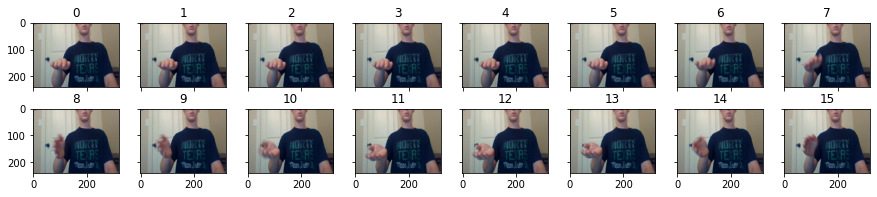

In [6]:
""" DEMO 1 WITHOUT IMAGE TRANSFORMS """
dataset = VideoFrameDataset(
        root_path=TRAIN_VIDEO_ROOT,
        annotationfile_path=TRAIN_ANNOTATIONS_ROOT,
        num_segments=16,
        frames_per_segment=1,
        imagefile_template='img_{:05d}.jpg',
        transform=None,
        random_shift=True,
        test_mode=False
    )

sample = dataset[0]
frames = sample[0]  # list of PIL images
label = sample[1]   # integer label

plot_video(rows=2, cols=8, frame_list=frames, plot_width=15., plot_height=3.)

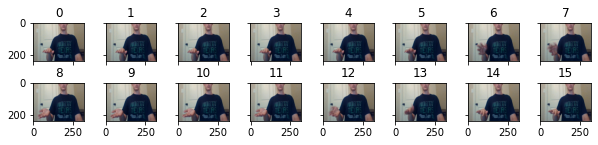

In [7]:
""" DEMO 2 SINGLE CONTINUOUS FRAME CLIP INSTEAD OF SAMPLED FRAMES, WITHOUT TRANSFORMS """
# If you do not want to use sparse temporal sampling, and instead
# want to just load N consecutive frames starting from a random
# start index, this is easy. Simply set NUM_SEGMENTS=1 and
# FRAMES_PER_SEGMENT=N. Each time a sample is loaded, N
# frames will be loaded from a new random start index.
dataset = VideoFrameDataset(
    root_path=TRAIN_VIDEO_ROOT,
    annotationfile_path=TRAIN_ANNOTATIONS_ROOT,
    num_segments=16,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=None,
    random_shift=True,
    test_mode=False
)

sample = dataset[3]
frames = sample[0]  # list of PIL images
label = sample[1]  # integer label

plot_video(rows=2, cols=8, frame_list=frames, plot_width=10., plot_height=5.)

Video Tensor Size: torch.Size([16, 3, 96, 96])


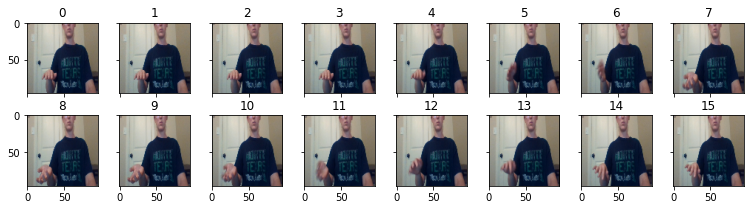

In [8]:
""" DEMO 3 WITH TRANSFORMS """
# As of torchvision 0.8.0, torchvision transforms support batches of images
# of size (BATCH x CHANNELS x HEIGHT x WIDTH) and apply deterministic or random
# transformations on the batch identically on all images of the batch. Any torchvision
# transform for image augmentation can thus also be used  for video augmentation.
preprocess = transforms.Compose([
    ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    transforms.Resize((96, 96)),  # image batch, resize to 100x160
    #transforms.RandomCrop(140, 100),
    #transforms.CenterCrop(96),  # image batch, center crop to square 96x96
    #t.GroupResize((100, 160)),
    #t.GroupRandomCrop((140, 100)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = VideoFrameDataset(
    root_path=TRAIN_VIDEO_ROOT,
    annotationfile_path=TRAIN_ANNOTATIONS_ROOT,
    num_segments=16,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=preprocess,
    random_shift=True,
    test_mode=False
)

sample = dataset[2]
frame_tensor = sample[0]  # tensor of shape (NUM_SEGMENTS*FRAMES_PER_SEGMENT) x CHANNELS x HEIGHT x WIDTH
label = sample[1]  # integer label

print('Video Tensor Size:', frame_tensor.size())

def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


frame_tensor = denormalize(frame_tensor)
plot_video(rows=2, cols=8, frame_list=frame_tensor, plot_width=15., plot_height=3.)

In [9]:
train_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

In [10]:
val_dataset = VideoFrameDataset(
        root_path=VALIDATION_VIDEO_ROOT,
        annotationfile_path=VALIDATION_ANNOTATIONS_ROOT,
        num_segments=16,
        frames_per_segment=1,
        imagefile_template='img_{:05d}.jpg',
        transform=preprocess,
        random_shift=True,
        test_mode=True
    )

validation_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

In [11]:
import torch
import torch.nn as nn
import math

class FullModel(nn.Module):

    def __init__(self, batch_size, seq_length=8):
        super(FullModel, self).__init__()
        
        class CNN2D(nn.Module):
            def __init__(self, batch_size=batch_size, image_size=96, seq_length=8, in_channels=3):
                super(CNN2D, self).__init__()
                self.conv1 = self._create_conv_layer(in_channels=in_channels, out_channels=16)
                self.conv2 = self._create_conv_layer(in_channels=16, out_channels=32)
                self.conv3 = self._create_conv_layer_pool(in_channels=32, out_channels=64)
                self.conv4 = self._create_conv_layer_pool(in_channels=64, out_channels=128)
                self.conv5 = self._create_conv_layer_pool(in_channels=128, out_channels=256)
                cnn_output_shape = int(256*(image_size/(2**4))**2)

            def forward(self, x):
                batch_size, frames, channels, width, height = x.shape
                x = x.view(-1, channels, width, height)
                x = self.conv1(x)
                x = self.conv2(x)
                x = self.conv3(x)
                x = self.conv4(x)
                x = self.conv5(x)
                return x
            
            def _create_conv_layer(self,in_channels, out_channels, kernel_size=(3,3), padding=(1,1)):
                return nn.Sequential(
                        nn.Conv2d(in_channels,out_channels, kernel_size, padding=padding),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                    )

            def _create_conv_layer_pool(self,in_channels, out_channels, kernel_size=(3,3), padding=(1,1), pool=(2,2)):
                return nn.Sequential(
                        nn.Conv2d(in_channels,out_channels, kernel_size, padding=padding),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                        nn.MaxPool2d(pool)
                    )

        class CNN3D(nn.Module):
            def __init__(self, batch_size=batch_size, image_size=96, seq_length=8):
                super(CNN3D, self).__init__()
                self.conv1 = self._create_conv_layer_pool(in_channels=256, out_channels=256, pool=(1,1,1))
                self.conv2 = self._create_conv_layer_pool(in_channels=256, out_channels=256, pool=(2,2,2))
                self.conv3 = self._create_conv_layer_pool(in_channels=256, out_channels=256, pool=(2,1,1))
                self.conv4 = self._create_conv_layer_pool(in_channels=256, out_channels=256, pool=(2,2,2))

            def forward(self, x):
                batch_size, channels, frames, width, height = x.shape
                x = self.conv1(x)
                x = self.conv2(x)
                x = self.conv3(x)
                x = self.conv4(x)
                return x

            def _create_conv_layer(self,in_channels, out_channels, kernel_size=(3,3,3), padding=(1,1,1)):
                return nn.Sequential(
                        nn.Conv3d(in_channels,out_channels, kernel_size, padding=padding),
                        nn.BatchNorm3d(out_channels),
                        nn.ReLU(),
                    )

            def _create_conv_layer_pool(self,in_channels, out_channels, kernel_size=(3,3,3), padding=(1,1,1), pool=(1,2,2)):
                return nn.Sequential(
                        nn.Conv3d(in_channels,out_channels, kernel_size, padding=padding),
                        nn.BatchNorm3d(out_channels),
                        nn.ReLU(),
                        nn.MaxPool3d(pool)
                    )


        class Combiner(nn.Module):
            
            def __init__(self, in_features):
                super(Combiner, self).__init__()
                self.linear1 = self._create_linear_layer(in_features , in_features//2)
                self.linear2 = self._create_linear_layer(in_features//2 , 1024)
                self.linear3 = self._create_linear_layer(1024 , 6)
                #self.linear3 = self._create_last_linear_layer(1024 , 6)

            def forward(self, x):
                x = self.linear1(x)
                x = self.linear2(x)
                x = self.linear3(x)
                return x;

            def _create_linear_layer(self, in_features, out_features, p=0.6):
                return nn.Sequential(
                    nn.Linear(in_features, out_features),
                    nn.Dropout(p=p)
                )
            
            def _create_last_linear_layer(self, in_features, out_features, p=0.6):
                return nn.Sequential(
                    nn.Linear(in_features, out_features),
                    nn.Softmax(out_features)
                )

        self.rgb2d = CNN2D(batch_size)
        self.rgb3d = CNN3D(batch_size)
        self.combiner = Combiner(4608)

        self.batch_size = batch_size
        self.seq_length = seq_length
        self.steps = 0
        self.steps = 0
        self.epochs = 0
        self.best_validation_loss = math.inf

    def forward(self, x):
        self.batch_size = x.shape[0]
        x = self.rgb2d(x)
        batch_and_frames, channels, dim1, dim2 = x.shape
        x = x.view(self.batch_size, -1, channels, dim1, dim2).permute(0,2,1,3,4)
        x = self.rgb3d(x)
        x = x.view(self.batch_size, -1)
        x = self.combiner(x)

        if self.training:
            self.steps += 1

        return x

In [12]:
batch_size = 1
steps_before_print = 100
num_workers = 1
step_size = 4
num_frames = 32 // step_size

In [13]:
model = FullModel(batch_size=batch_size)

In [14]:
print(model)

FullModel(
  (rgb2d): CNN2D(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): M

In [15]:
curr_dir = os.getcwd()
curr_dir

'/home/ian/Documents/UNT/wearables/kaggle/video'

In [16]:
def save_model(model, use_ts=False):
    if use_ts:
        time_stamp = time.strftime("%d_%b_%Y_%Hh%Mm", time.gmtime())
        torch.save(model.state_dict(), curr_dir + '/{}.ckp'.format(time_stamp))
    else:
        torch.save(model.state_dict(), curr_dir + '/{}.ckp'.format('best_model'))

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
# if torch.cuda.is_available():
#     print('Cuda is available!')
#     model.cuda()
# else:
print("NO")

Cuda is available!


In [19]:
def calculate_loss_and_accuracy(validation_loader, model, criterion, stop_at = 1200, print_every=99999):
    correct = 0
    total = 0
    steps = 0
    total_loss = 0
    sz = len(validation_loader)
    
    for images, labels in validation_loader:
    
        if total%print_every == 0 and total > 0:
            accuracy = 100 * correct / total
            print(accuracy)
        
        if total >= stop_at:
            break
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Forward pass only to get logits/output
        outputs = model(images)

        #Get Loss for validation data
        loss = criterion(outputs, labels)
        total_loss += loss.item()


        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)
        steps += 1

        correct += (predicted == labels).sum().item()

        del outputs, loss, _, predicted

    accuracy = 100 * correct / total
    return total_loss/steps, accuracy

In [20]:
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [21]:
def train(epochs):
    
    print("Training is about to start...")
    best_validation_loss = model.best_validation_loss

    for epoch in range(epochs):
        step = 0
        epoch_loss = 0
        epoch_acc = 0
        times_calculated = 0
        total_size = len(train_loader)
        for i, (images, labels) in enumerate(train_loader): # set of 16 images, labels
            model.train()

            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            #print('training_loss', loss.item(), model.steps)
            loss.backward()
            optimizer.step()

            step += 1
            epoch_loss += loss.item()
            
            
            if step % steps_before_print == 0:
                
                print('Calculating accuracy')
                # Calculate Accuracy
                model.eval()
                validation_loss, accuracy = calculate_loss_and_accuracy(validation_loader, model, criterion, stop_at = 1200)
                print(f'Epoch: {model.epochs}, step: {step} validation_loss', validation_loss, model.steps)
                print('accuracy', accuracy, model.steps)
                epoch_acc += accuracy
                times_calculated += 1
                # Print Loss
                print('Iteration: {}/{} - ({:.2f}%). Loss: {}. Accuracy: {}'.format(step, total_size, step*100/total_size , loss.item(), accuracy))
                if validation_loss < model.best_validation_loss:
                    model.best_valdiation_loss = validation_loss
                    print('Saving best model')
                    save_model(model)
                del validation_loss
            del loss, outputs, images, labels
            

        model.epochs += 1

        #print('Epoch({}) avg loss: {} avg acc: {}'.format(epoch, epoch_loss/step, epoch_acc/times_calculated))
        print('Epoch ', epoch)
        save_model(model, use_ts=True)

In [22]:
train(10)

Training is about to start...
Calculating accuracy
Epoch: 0, step: 100 validation_loss 5.720214039577148 100
accuracy 18.803418803418804 100
Iteration: 100/660 - (15.15%). Loss: 32.96505355834961. Accuracy: 18.803418803418804
Saving best model
Calculating accuracy
Epoch: 0, step: 200 validation_loss 15.6315521949478 200
accuracy 17.094017094017094 200
Iteration: 200/660 - (30.30%). Loss: 1.3862978219985962. Accuracy: 17.094017094017094
Saving best model
Calculating accuracy
Epoch: 0, step: 300 validation_loss 5.050840158302051 300
accuracy 13.675213675213675 300
Iteration: 300/660 - (45.45%). Loss: 1.7917593717575073. Accuracy: 13.675213675213675
Saving best model
Calculating accuracy
Epoch: 0, step: 400 validation_loss 5.944046416057226 400
accuracy 17.94871794871795 400
Iteration: 400/660 - (60.61%). Loss: 17.83548355102539. Accuracy: 17.94871794871795
Saving best model
Calculating accuracy
Epoch: 0, step: 500 validation_loss 6.190404105437999 500
accuracy 17.94871794871795 500
Itera

In [ ]:
# view models saved
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
def load_checkpoint(filepath):
    checkpoint_dict = torch.load(filepath)
    model.load_state_dict(checkpoint_dict)
    
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [ ]:
# load model
working_dir = Path(Path(os.getcwd()).joinpath("best_model.ckp"))
working_dir
loaded_model = load_checkpoint(str(working_dir))

In [ ]:
# test data loader
test_dataset = VideoFrameDataset(
        root_path=TEST_VIDEO_ROOT,
        annotationfile_path=TEST_ANNOTATIONS_ROOT,
        num_segments=16,
        frames_per_segment=1,
        imagefile_template='img_{:05d}.jpg',
        transform=preprocess,
        random_shift=True,
        test_mode=True
    )

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

In [ ]:
def generate_prediction_file(test_loader, model, criterion, stop_at = 1200, print_every=99999):
    correct = 0
    total = 0
    steps = 0
    total_loss = 0
    
    size = len(validation_loader)
    model.eval()
    
    f = open("my_submission.csv", "a")
    f.write("id, gesture\n")
    
    
    for (images, labels), video_name in zip(test_loader, test_dataset.video_list):
        
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        # Forward pass only to get logits/output
        outputs = model(images)

        #Get Loss for validation data
        loss = criterion(outputs, labels)
        total_loss += loss.item()


        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        #Get Loss for test data
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        # Total number of labels
        total += labels.size(0)
        steps += 1
        
        correct += (predicted == labels).sum().item()
        
        # gets the video id
        video_id = video_name.path.split("/")[-1]
        
        # gets the predicted video class id
        pred_class = int(predicted[0])
        
        # write to file
        f.write(f"{video_id}, {pred_class}\n")
        
        del outputs, loss, _, predicted
        
        top1 = 100 * correct / total
    
    f.close()
    print("my_submission.csv has been generated in kaggle/working directory")
    return total_loss/steps, top1

In [ ]:
generate_prediction_file(test_loader, loaded_model, criterion)

my_submission.csv has been generated in kaggle/working directory


(6.185180964353292, 18.115942028985508)

In [ ]:
# view files saved
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# go to the top right corner in Data,
# select the output, and download my_submission.csv along with your models you would like to save

In [ ]:
# os.remove("/kaggle/working/my_submission.csv")

In [ ]:
predicted = []
actual = []

for i, (images, labels) in enumerate(test_loader):
    model.eval()
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        actual.append(labels[0].item())
    #print(type(images))
    pred = model(images)
    #print(f'Label: {labels[0]}')
    #print(pred[0])
    predicted_class = np.argmax(pred[0].cpu().data.numpy().argmax())
    predicted.append(predicted_class)
    #print(f'Predicted Class: {predicted_class}, ACtual Class: {labels[0]}')

In [ ]:
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(actual, predicted)
import seaborn as sns
sns.heatmap(c_mat, annot=True)